In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


torch.manual_seed(42)


device = torch.device("mps")


transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_data = datasets.ImageFolder("images/train", transform=transform)
validation_data = datasets.ImageFolder("images/validation", transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=False)


class AlexNet(nn.Module):
    def __init__(self, num_classes=7):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Create an instance of the AlexNet model
model = AlexNet(num_classes=7).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 30
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_data)
    epoch_acc = running_corrects.float() / len(train_data)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_loss = val_loss / len(validation_data)
    val_acc = val_corrects.float() / len(validation_data)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Train Acc: {epoch_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")


torch.save(model.state_dict(), 'models/alexnet_model_30epochs.pth')

Epoch 1/30 - Train Loss: 1.8613 - Train Acc: 0.2459 - Val Loss: 1.8120 - Val Acc: 0.2583
Epoch 2/30 - Train Loss: 1.8085 - Train Acc: 0.2485 - Val Loss: 1.7995 - Val Acc: 0.2583
Epoch 3/30 - Train Loss: 1.7935 - Train Acc: 0.2517 - Val Loss: 1.7727 - Val Acc: 0.2600
Epoch 4/30 - Train Loss: 1.7711 - Train Acc: 0.2635 - Val Loss: 1.7487 - Val Acc: 0.2958
Epoch 5/30 - Train Loss: 1.7521 - Train Acc: 0.2832 - Val Loss: 1.7175 - Val Acc: 0.3155
Epoch 6/30 - Train Loss: 1.7283 - Train Acc: 0.3008 - Val Loss: 1.6805 - Val Acc: 0.3399
Epoch 7/30 - Train Loss: 1.6890 - Train Acc: 0.3234 - Val Loss: 1.6414 - Val Acc: 0.3602
Epoch 8/30 - Train Loss: 1.6399 - Train Acc: 0.3561 - Val Loss: 1.6011 - Val Acc: 0.3817
Epoch 9/30 - Train Loss: 1.6023 - Train Acc: 0.3756 - Val Loss: 1.5800 - Val Acc: 0.3971
Epoch 10/30 - Train Loss: 1.5685 - Train Acc: 0.3929 - Val Loss: 1.5450 - Val Acc: 0.4083
Epoch 11/30 - Train Loss: 1.5371 - Train Acc: 0.4064 - Val Loss: 1.5198 - Val Acc: 0.4195
Epoch 12/30 - Train

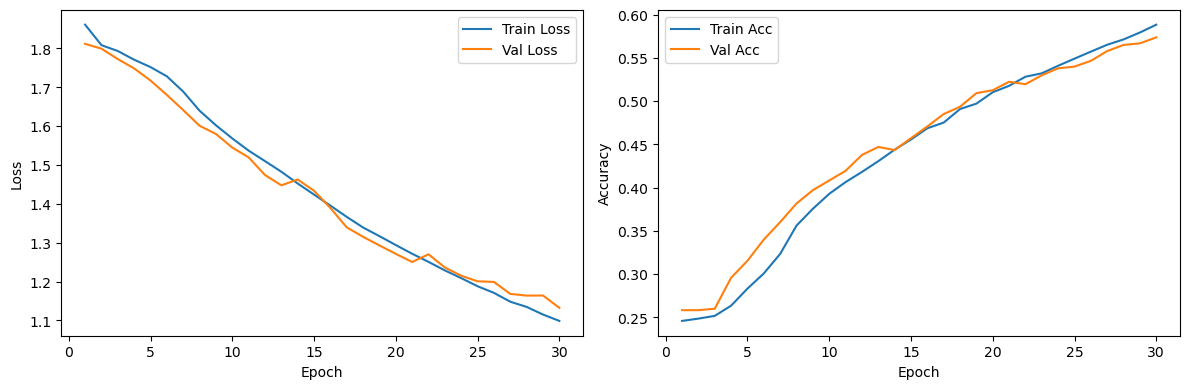

In [10]:
# Plot training history
train_losses = [loss for loss in train_losses]
val_losses = [loss for loss in val_losses]
train_accs = [acc for acc in train_accs]
val_accs = [acc for acc in val_accs]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), [acc.item() for acc in train_accs], label='Train Acc')
plt.plot(range(1, num_epochs + 1), [acc.item() for acc in val_accs], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Test Accuracy: 0.5739


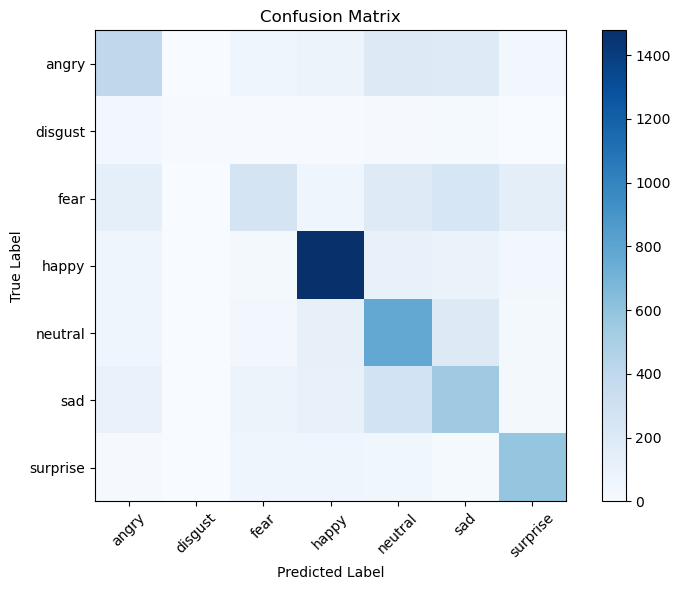

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


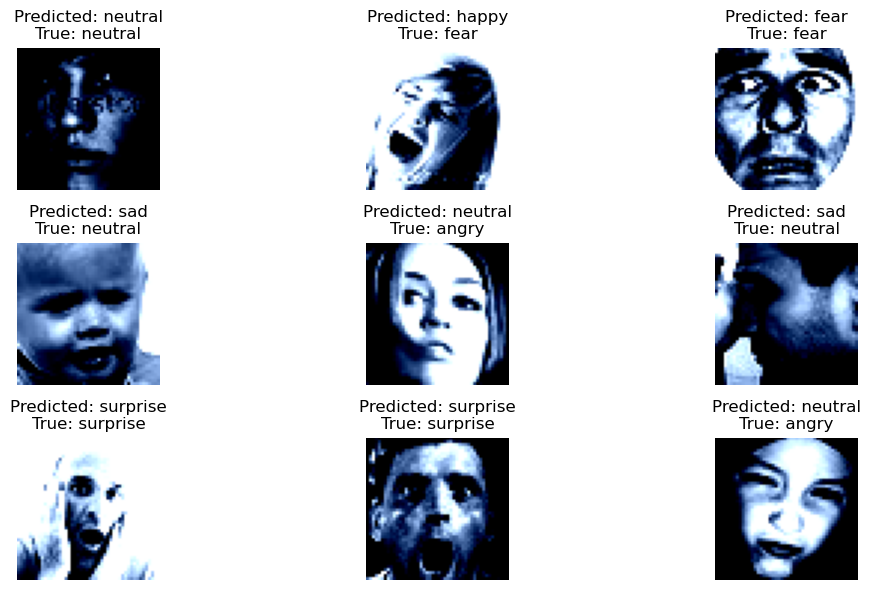

In [25]:
# Load the test dataset
test_dataset = datasets.ImageFolder('images/validation', transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
model = AlexNet(num_classes=7).to(device)

# Load the trained model weights
model.load_state_dict(torch.load('models/alexnet_model_30epochs.pth'))

# Evaluate the model
model.eval()
total_correct = 0
total_samples = 0
predictions = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.cpu().numpy())
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

accuracy = total_correct / total_samples
print(f"Test Accuracy: {accuracy:.4f}")

# Convert predictions and labels to numpy arrays
predictions = np.array(predictions)
labels = test_dataset.targets

# Plot a confusion matrix
num_classes = len(test_dataset.classes)
confusion_matrix = np.zeros((num_classes, num_classes))
for i in range(len(predictions)):
    confusion_matrix[labels[i], predictions[i]] += 1

plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(num_classes), test_dataset.classes, rotation=45)
plt.yticks(np.arange(num_classes), test_dataset.classes)
plt.tight_layout()
plt.show()

# Set the figure size
plt.figure(figsize=(12, 6))

# Iterate over the images
for i in range(9):
    index = np.random.randint(len(predictions))
    image, label = test_dataset[index]
    image = image.permute(1, 2, 0)  # Reshape image tensor for visualization
    predicted_class = test_dataset.classes[predictions[index]]
    true_class = test_dataset.classes[label]
    
    # Create subplots in a 3x3 grid
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}\nTrue: {true_class}')
    plt.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

Test Accuracy: 0.5739


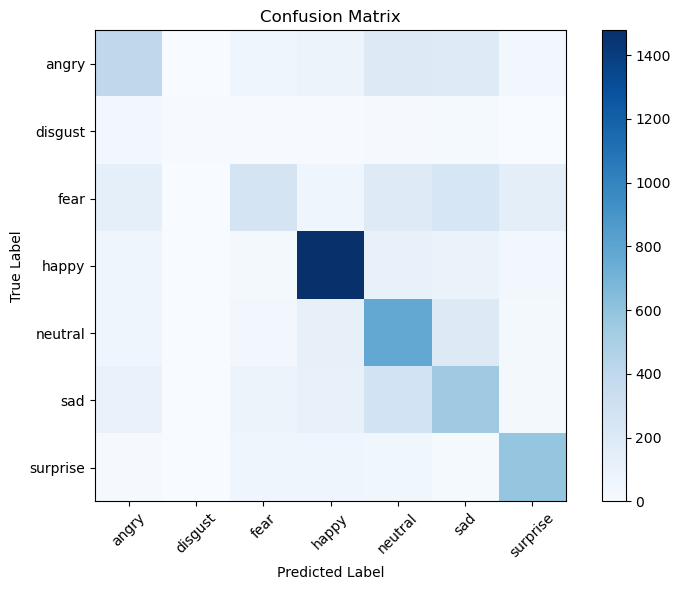

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


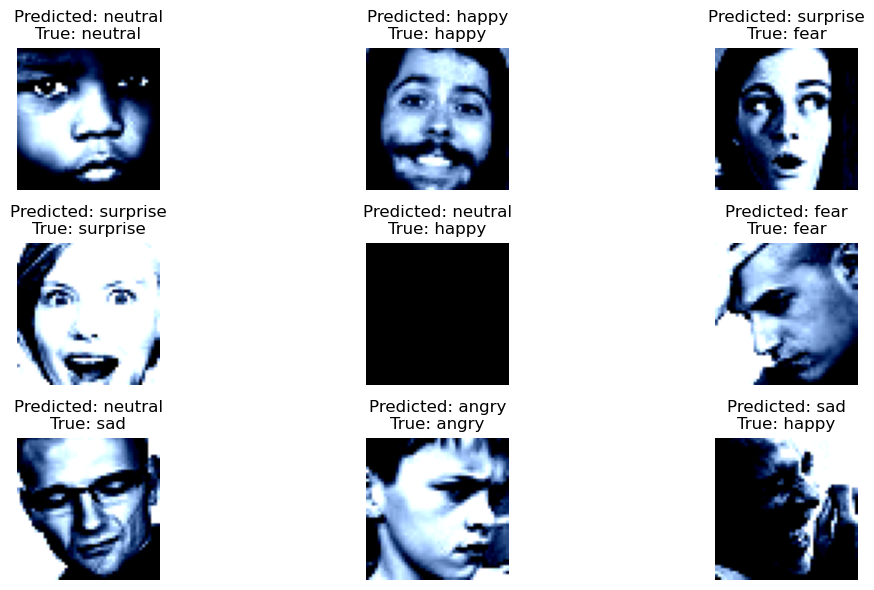

In [27]:
# Load the test dataset
test_dataset = datasets.ImageFolder('images/validation', transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
model = AlexNet(num_classes=7).to(device)

# Load the trained model weights
model.load_state_dict(torch.load('models/alexnet_model_30epochs.pth'))

# Evaluate the model
model.eval()
total_correct = 0
total_samples = 0
predictions = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.cpu().numpy())
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

accuracy = total_correct / total_samples
print(f"Test Accuracy: {accuracy:.4f}")

# Convert predictions and labels to numpy arrays
predictions = np.array(predictions)
labels = test_dataset.targets

# Plot a confusion matrix
num_classes = len(test_dataset.classes)
confusion_matrix = np.zeros((num_classes, num_classes))
for i in range(len(predictions)):
    confusion_matrix[labels[i], predictions[i]] += 1

